In [3]:
from google.colab import files
uploaded = files.upload()


Saving a1_run_f87f42ba66.jsonl to a1_run_f87f42ba66 (1).jsonl


In [4]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.dpi"] = 140


In [5]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

def read_jsonl(path: str) -> list[dict]:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return rows

def normalize_log(path: str, label: str | None = None) -> pd.DataFrame:
    rows = read_jsonl(path)
    if label is None:
        label = Path(path).stem  # fallback

    out = []
    for r in rows:
        if r.get("event") != "calib_update":
            continue

        t_global = r.get("t_global", None)
        k_used = r.get("k_used_total", None)

        if isinstance(r.get("metrics"), dict):
            m = r["metrics"]
            for key, val in m.items():
                if val is None:
                    continue
                if isinstance(val, (int, float)) and np.isfinite(val):
                    out.append({
                        "label": label,
                        "t_global": t_global,
                        "k_used_total": k_used,
                        "metric": key,
                        "value": float(val),
                    })
            continue
        # metrics_after + acc/theta_mean_abs
        m_after = r.get("metrics_after") or {}
        for key in ["loss", "pos_mse", "bat_mse"]:
            val = m_after.get(key, None)
            if val is None:
                continue
            out.append({
                "label": label,
                "t_global": t_global,
                "k_used_total": k_used,
                "metric": key,
                "value": float(val),
            })

        acc = r.get("acc") or {}
        # у старих логах було acc: {"acc/theta_mean_abs": ...}
        if "acc/theta_mean_abs" in acc and acc["acc/theta_mean_abs"] is not None:
            out.append({
                "label": label,
                "t_global": t_global,
                "k_used_total": k_used,
                "metric": "theta_mean_abs",
                "value": float(acc["acc/theta_mean_abs"]),
            })

    df = pd.DataFrame(out)
    if df.empty:
        return df

    df["t_global"] = pd.to_numeric(df["t_global"], errors="coerce")
    df["k_used_total"] = pd.to_numeric(df["k_used_total"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["t_global", "value"]).sort_values(["label", "metric", "t_global"]).reset_index(drop=True)
    return df


In [6]:
paths = {
    "A1": "/content/a1_run_f87f42ba66.jsonl",
    # "A2": "/content/a2_run_....jsonl",
    # "A3": "/content/a3_run_....jsonl",
    # "A4": "/content/a4_run_....jsonl",
    # "A5": "/content/a5_run_....jsonl",
    # "PPO": "/content/ppo_calib_....jsonl",
}

dfs = []
for lab, p in paths.items():
    df = normalize_log(p, label=lab)
    print(lab, "rows:", len(df))
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
all_df.head()


A1 rows: 14536


,label,t_global,k_used_total,metric,value
0,A1,10,1,bat_mse,0.0
1,A1,34,2,bat_mse,0.0
2,A1,54,3,bat_mse,0.0
3,A1,72,4,bat_mse,0.0
4,A1,84,5,bat_mse,0.0


In [7]:
def read_jsonl(path: str) -> list[dict]:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return rows

def _flatten(d: dict, prefix: str = "") -> dict:
    out = {}
    for k, v in (d or {}).items():
        kk = f"{prefix}{k}" if prefix == "" else f"{prefix}.{k}"
        if isinstance(v, dict):
            out.update(_flatten(v, kk))
        else:
            out[kk] = v
    return out

def load_a1_like_log(path: str, label: str = "A1") -> tuple[pd.DataFrame, pd.DataFrame]:
    rows = read_jsonl(path)

    step_rows = []
    upd_rows = []

    for r in rows:
        ev = r.get("event")
        base = {
            "label": label,
            "event": ev,
            "ep": r.get("ep"),
            "seed": r.get("seed"),
            "t_global": r.get("t_global"),
            "t_ep": r.get("t_ep"),
            "k_used_total": r.get("k_used_total"),
        }

        if ev == "step":
            rr = base | {
                "queried_oracle": r.get("queried_oracle", 0),
                "action": r.get("action"),
                "reward_twin": r.get("reward_twin"),
            }
            step_rows.append(rr)

        elif ev == "calib_update":
            rr = base.copy()

            if isinstance(r.get("metrics"), dict):
                rr.update(_flatten(r["metrics"], prefix="metrics"))
            if isinstance(r.get("metrics_after"), dict):
                rr.update(_flatten(r["metrics_after"], prefix="metrics"))
            if isinstance(r.get("acc"), dict):
                if "acc/theta_mean_abs" in r["acc"]:
                    rr["metrics.theta_mean_abs"] = r["acc"]["acc/theta_mean_abs"]
            if isinstance(r.get("theta_after"), dict):
                rr.update(_flatten(r["theta_after"], prefix="theta_est"))
            # some logs might store "theta" instead; keep fallback
            if isinstance(r.get("theta"), dict) and "theta_est.battery_max" not in rr:
                rr.update(_flatten(r["theta"], prefix="theta_est"))

            upd_rows.append(rr)

    steps_df = pd.DataFrame(step_rows)
    upd_df = pd.DataFrame(upd_rows)

    # numeric coercions
    for df in [steps_df, upd_df]:
        for c in ["ep", "seed", "t_global", "t_ep", "k_used_total", "queried_oracle", "reward_twin", "action"]:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")
        for c in df.columns:
            if c.startswith("metrics.") or c.startswith("theta_est."):
                df[c] = pd.to_numeric(df[c], errors="coerce")

    steps_df = steps_df.dropna(subset=["t_global"]).sort_values("t_global").reset_index(drop=True)
    upd_df = upd_df.dropna(subset=["t_global"]).sort_values("t_global").reset_index(drop=True)
    return steps_df, upd_df


In [11]:
def _style_ax(ax):
    ax.grid(True, which="both", ls="--", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def _rolling(series: pd.Series, win: int, kind: str = "mean") -> pd.Series:
    if win is None or win <= 1:
        return series
    r = series.rolling(win, min_periods=max(3, win // 10))
    return r.mean() if kind == "mean" else r.median()

def _need_col(df: pd.DataFrame, col: str):
    if col not in df.columns:
        raise KeyError(f"Missing column '{col}'")

def pick_theta_error_col_a1(upd: pd.DataFrame) -> str:
    for c in ["metrics.theta_mean_abs"]:
        if c in upd.columns:
            return c
    raise KeyError("No theta error column found. Expected 'metrics.theta_mean_abs'.")

def _pick_xcol(d: pd.DataFrame) -> str:
    for c in ["t_global", "k_used_total", "ep"]:
        if c in d.columns:
            return c
    raise KeyError("No column suitable for X-axis found.")

def _maybe_num(df: pd.DataFrame, col: str):
    if col not in df.columns:  return
    df[col] = pd.to_numeric(df[col], errors="coerce")

def prepare_df_for_plots(df: pd.DataFrame, mode: str | None, only_updates: bool) -> pd.DataFrame:
    d = df.copy()
    if mode is not None:
        _need_col(d, "run_type")
        d = d[d["run_type"] == mode].copy()

    if only_updates:
        _need_col(d, "event")
        d = d[d["event"].astype(str).eq("calib_update")].copy()

    return d

In [9]:
A1_LOG = "/content/a1_run_f87f42ba66.jsonl"
steps, upd = load_a1_like_log(A1_LOG, label="A1")

display(steps.head(3))
display(upd[[c for c in upd.columns if c in ["label","ep","t_global","k_used_total","metrics.loss","metrics.pos_mse","metrics.bat_mse","metrics.theta_mean_abs"]]].head(5))


,label,event,ep,seed,t_global,t_ep,k_used_total,queried_oracle,action,reward_twin
0,A1,step,0,0,0,0,1,1,2,-0.1
1,A1,step,0,0,1,1,1,0,2,-0.1
2,A1,step,0,0,2,2,1,0,2,-0.1


,label,ep,t_global,k_used_total,metrics.loss,metrics.pos_mse,metrics.bat_mse,metrics.theta_mean_abs
0,A1,0,10,1,0.0,0.0,0.0,2.171774
1,A1,1,34,2,0.0,0.0,0.0,2.171774
2,A1,2,54,3,0.0,0.0,0.0,2.171774
3,A1,3,72,4,0.0,0.0,0.0,3.107658
4,A1,4,84,5,0.0,0.0,0.0,3.107658


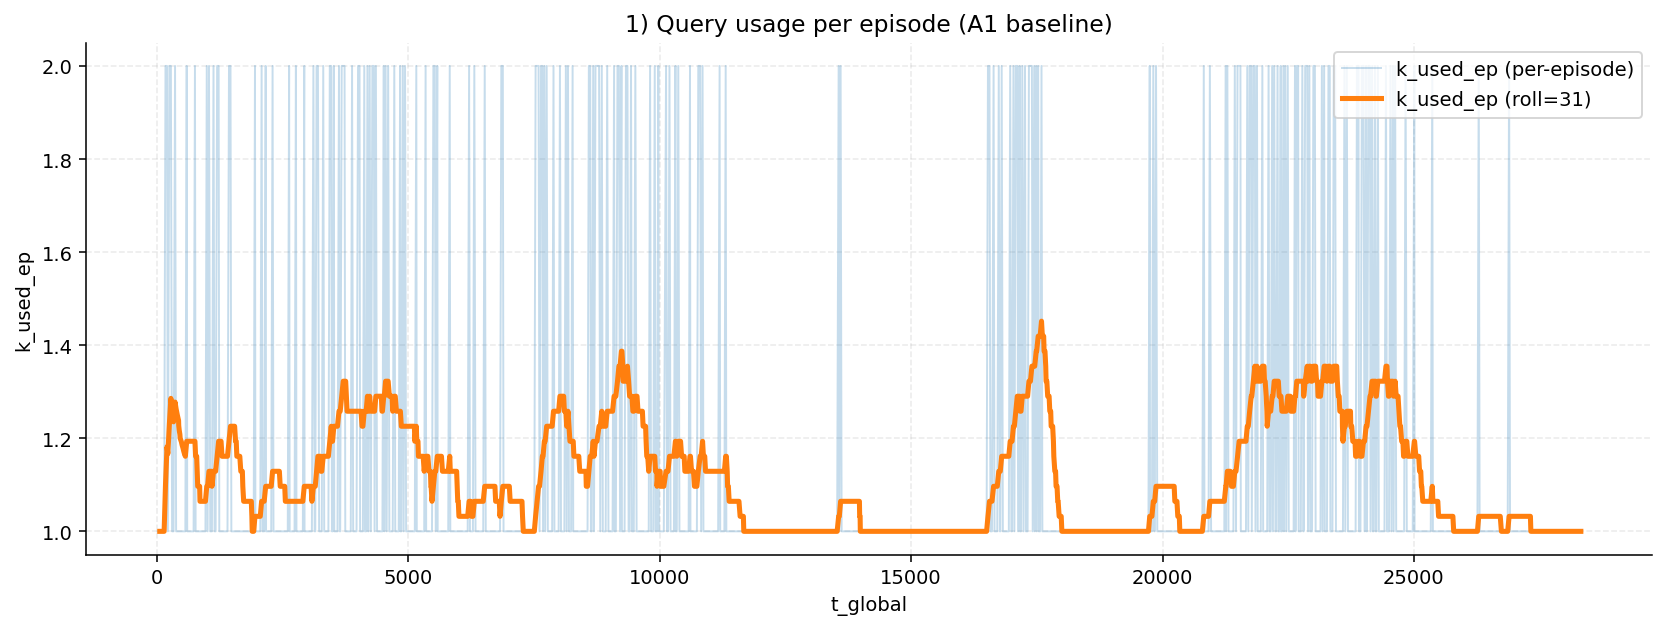

In [29]:
def plot_query_usage_a1(steps_df: pd.DataFrame, upd_df: pd.DataFrame, roll=31):
    _need_col(steps_df, "ep")
    _need_col(steps_df, "queried_oracle")
    _need_col(upd_df, "ep")
    _need_col(upd_df, "t_global")

    q_ep = (
        steps_df.dropna(subset=["ep"])
        .groupby("ep", as_index=False)["queried_oracle"]
        .sum()
        .rename(columns={"queried_oracle": "k_used_ep"})
    )

    anchor = upd_df.dropna(subset=["ep", "t_global"])[["ep", "t_global"]].drop_duplicates("ep", keep="last")
    d = q_ep.merge(anchor, on="ep", how="inner").sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d["t_global"], d["k_used_ep"], alpha=0.25, linewidth=1, label="k_used_ep (per-episode)")
    plt.plot(d["t_global"], _rolling(d["k_used_ep"], roll), linewidth=2.6, label=f"k_used_ep (roll={roll})")
    plt.title("1) Query usage per episode (A1 baseline)")
    plt.xlabel("t_global")
    plt.ylabel("k_used_ep")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()

plot_query_usage_a1(steps, upd, roll=31)


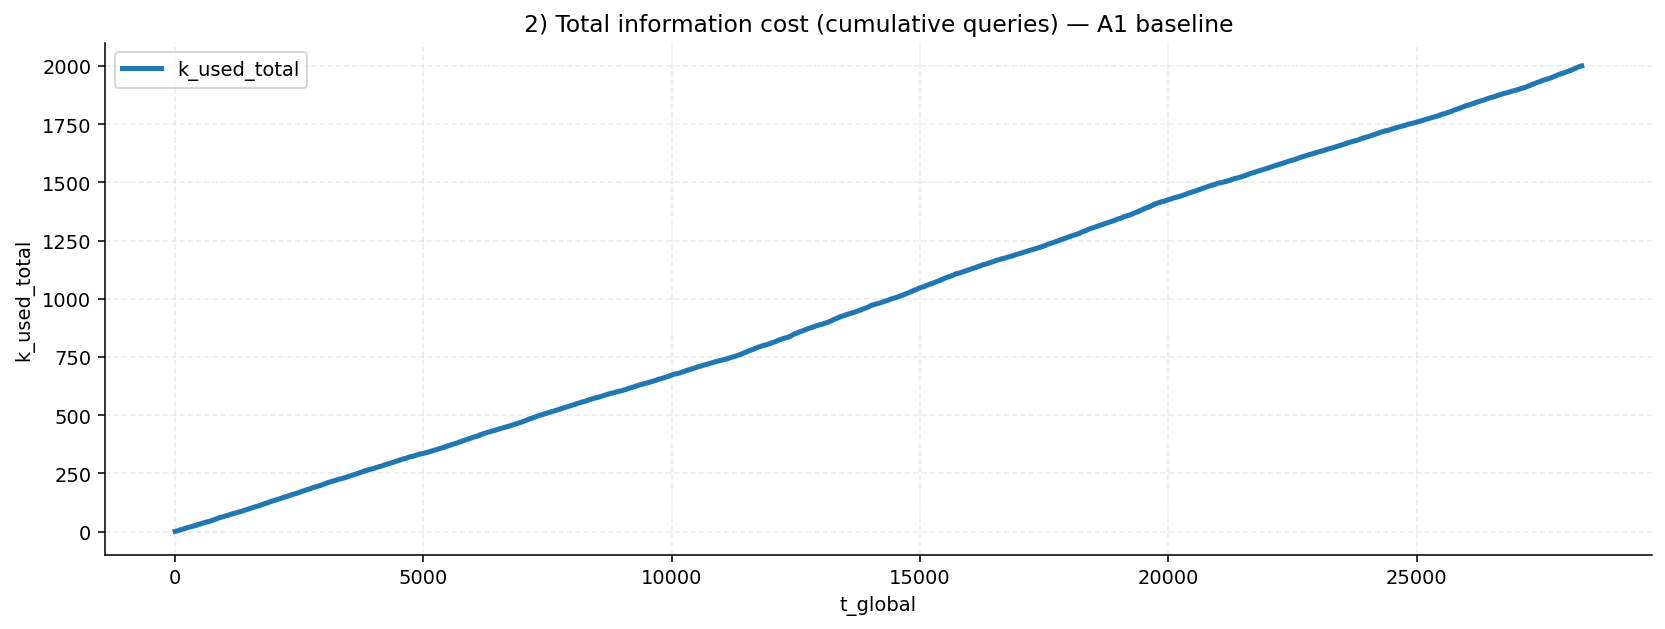

In [30]:
def plot_total_queries_a1(upd_df: pd.DataFrame):
    _need_col(upd_df, "k_used_total")
    _need_col(upd_df, "t_global")

    d = upd_df.dropna(subset=["t_global", "k_used_total"]).sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d["t_global"], d["k_used_total"], linewidth=2.6, label="k_used_total")
    plt.title("2) Total information cost (cumulative queries) — A1 baseline")
    plt.xlabel("t_global")
    plt.ylabel("k_used_total")
    _style_ax(plt.gca())
    plt.legend(loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()

plot_total_queries_a1(upd)


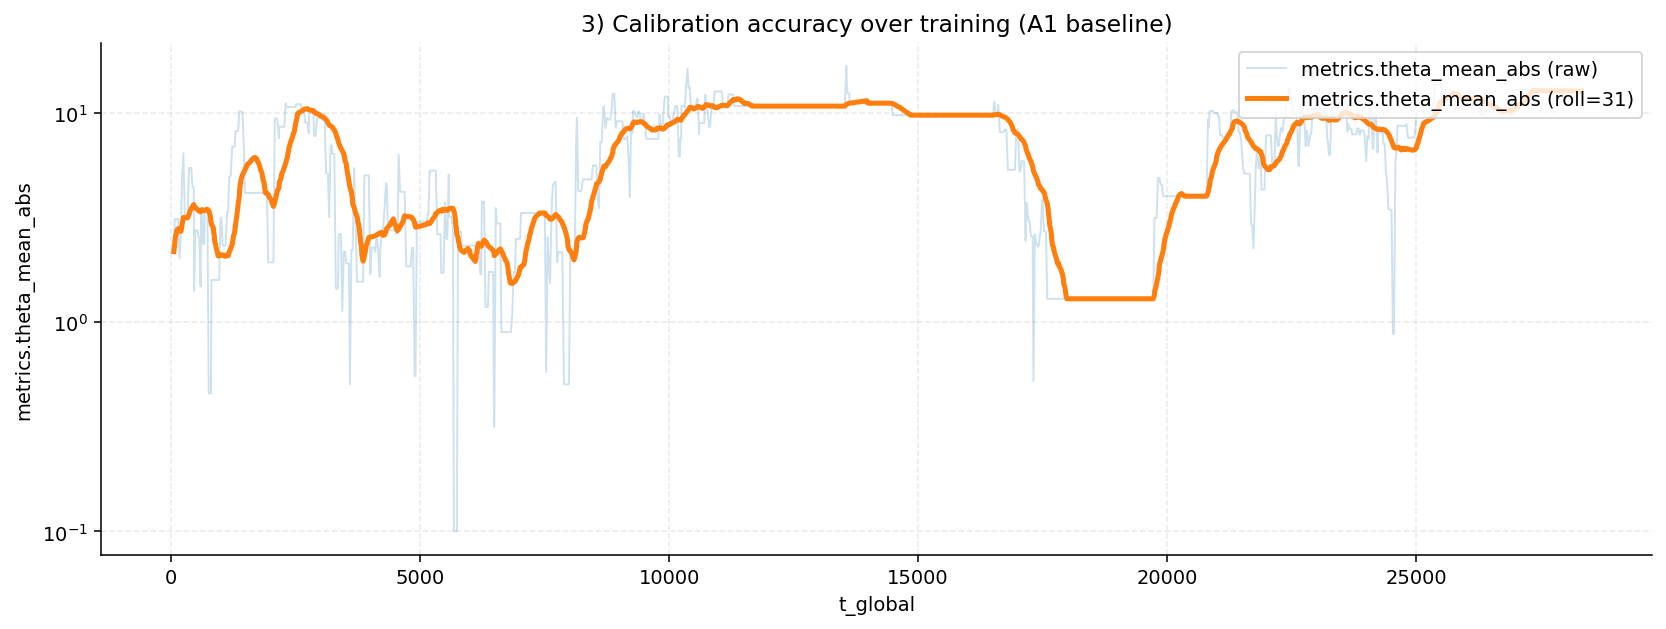

In [31]:
def plot_calibration_accuracy_a1(upd_df: pd.DataFrame, roll=31):
    ycol = pick_theta_error_col_a1(upd_df)
    d = upd_df.dropna(subset=["t_global", ycol]).sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d["t_global"], d[ycol], alpha=0.22, linewidth=1, label=f"{ycol} (raw)")
    plt.plot(d["t_global"], _rolling(d[ycol], roll), linewidth=2.6, label=f"{ycol} (roll={roll})")

    plt.title("3) Calibration accuracy over training (A1 baseline)")
    plt.xlabel("t_global")
    plt.ylabel(ycol)
    plt.yscale("symlog", linthresh=0.1)
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()

plot_calibration_accuracy_a1(upd, roll=31)


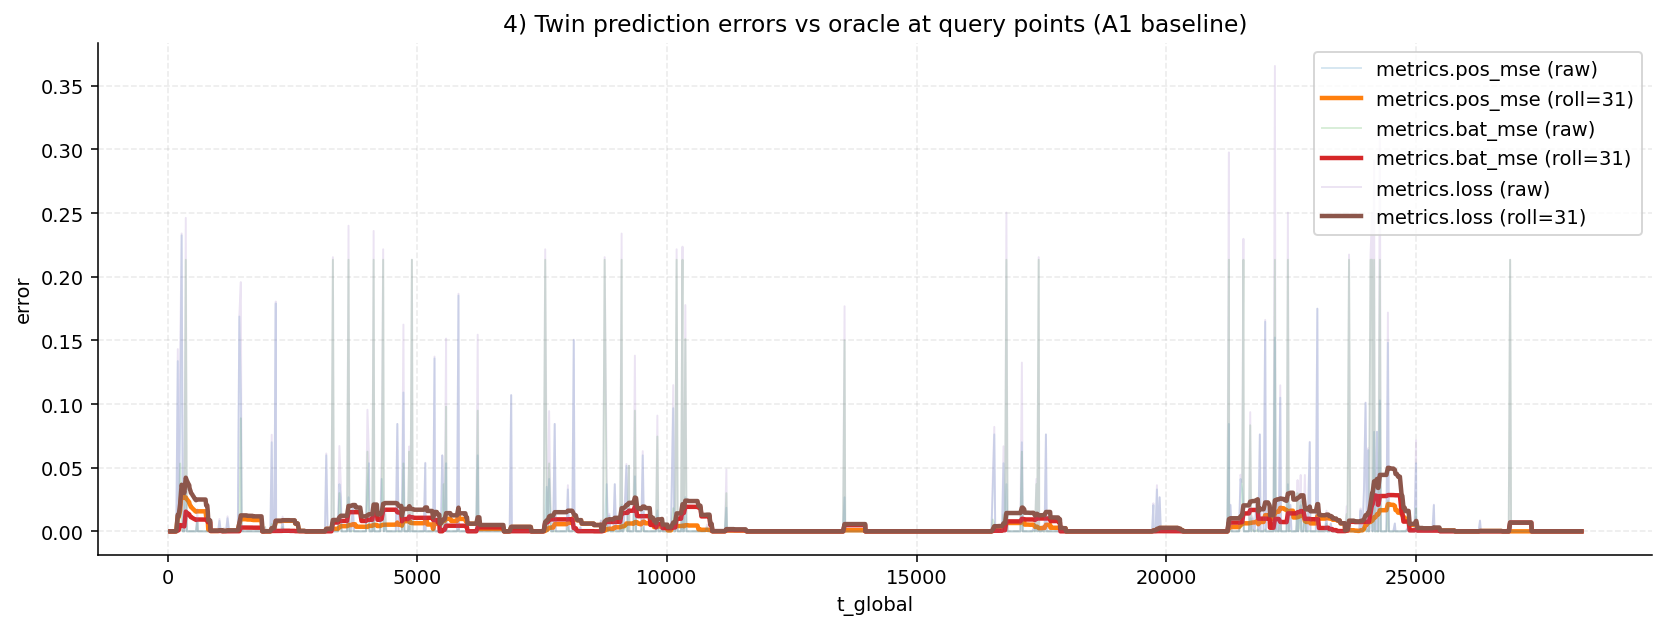

In [32]:
def plot_twin_prediction_errors_a1(upd_df: pd.DataFrame, roll=31):
    cols = ["metrics.pos_mse", "metrics.bat_mse", "metrics.loss"]
    available = [c for c in cols if c in upd_df.columns]
    if not available:
        raise KeyError(f"No expected error cols found. Expected one of: {cols}")

    d = upd_df.dropna(subset=["t_global"]).sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    for c in available:
        dd = d.dropna(subset=[c])
        if dd.empty:
            continue
        plt.plot(dd["t_global"], dd[c], alpha=0.18, linewidth=1, label=f"{c} (raw)")
        plt.plot(dd["t_global"], _rolling(dd[c], roll), linewidth=2.3, label=f"{c} (roll={roll})")

    plt.title("4) Twin prediction errors vs oracle at query points (A1 baseline)")
    plt.xlabel("t_global")
    plt.ylabel("error")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()

plot_twin_prediction_errors_a1(upd, roll=31)


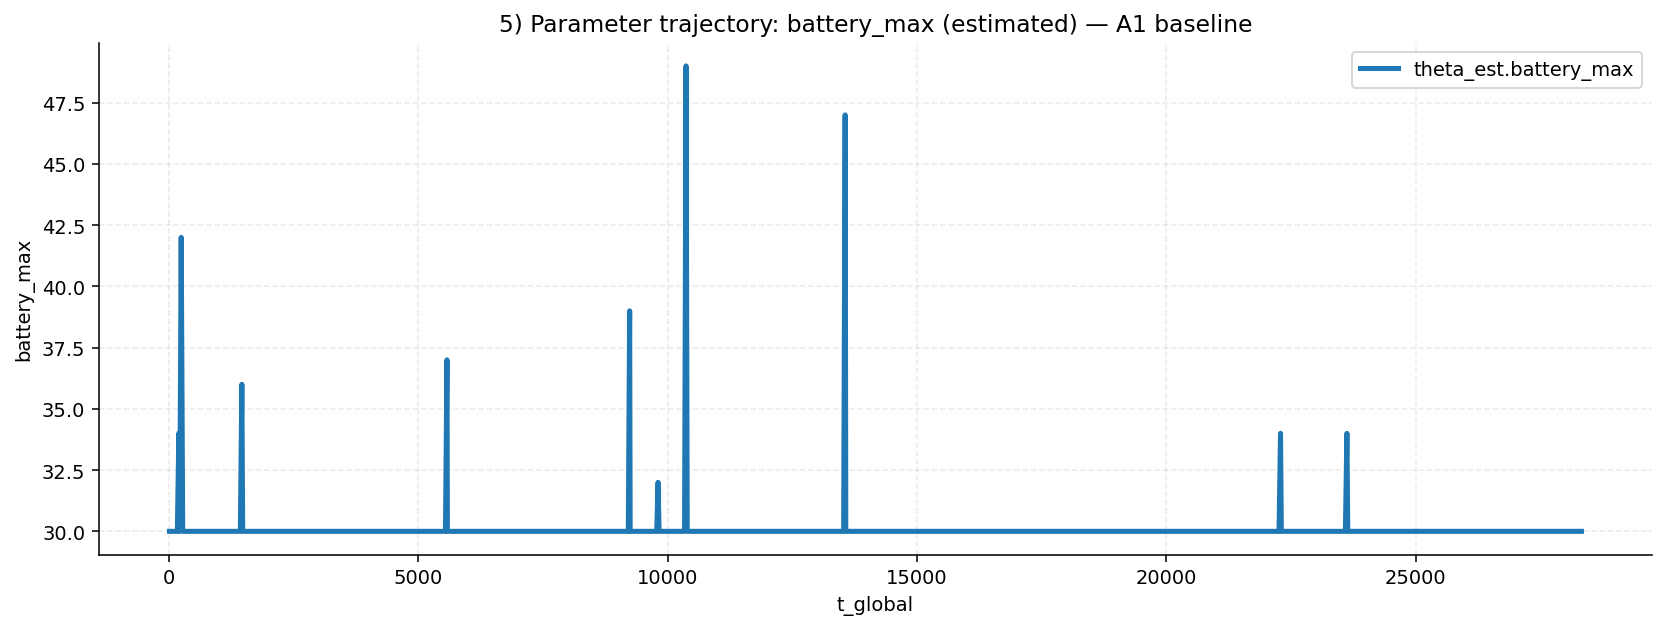

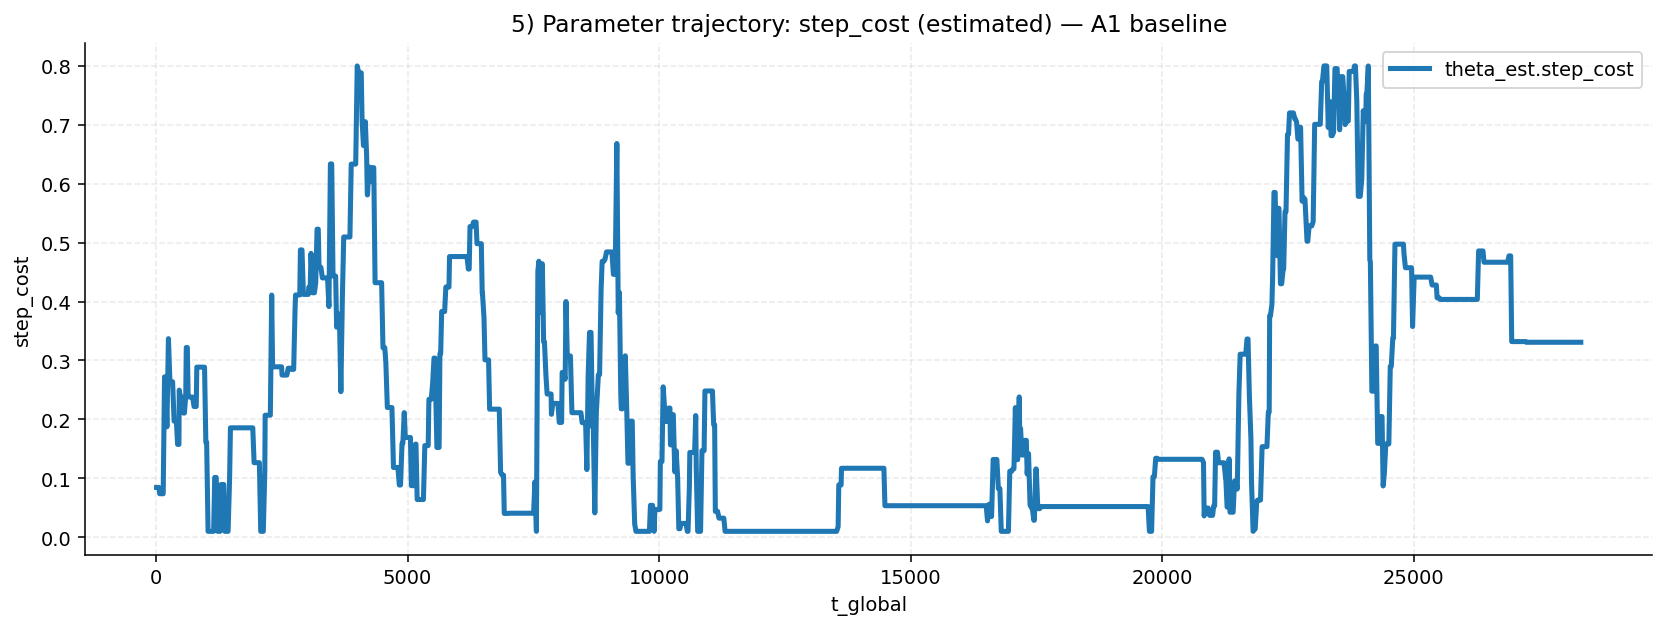

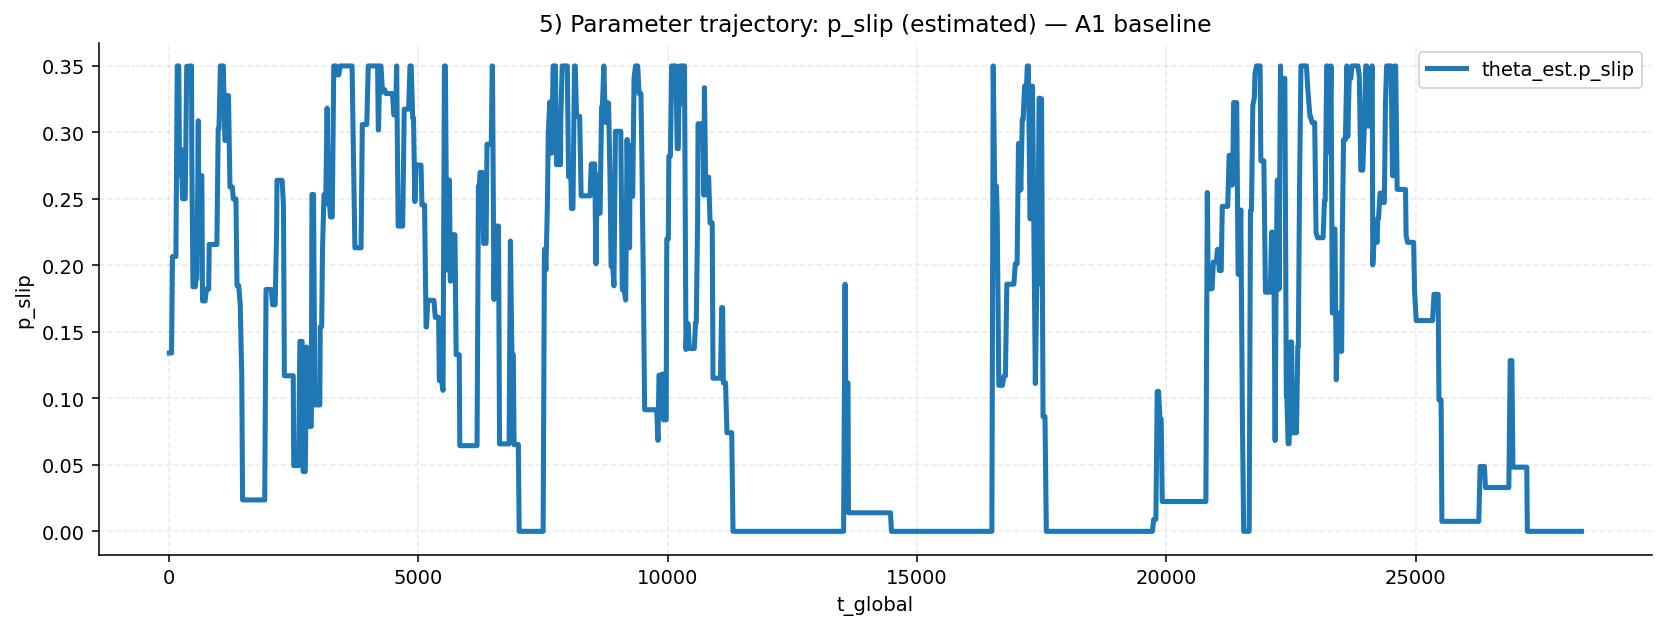

In [33]:
def plot_param_trajectory_a1(upd_df: pd.DataFrame, param: str):
    est_col = f"theta_est.{param}"
    _need_col(upd_df, "t_global")
    _need_col(upd_df, est_col)

    d = upd_df.dropna(subset=["t_global", est_col]).sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d["t_global"], d[est_col], linewidth=2.6, label=est_col)

    plt.title(f"5) Parameter trajectory: {param} (estimated) — A1 baseline")
    plt.xlabel("t_global")
    plt.ylabel(param)
    _style_ax(plt.gca())
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

plot_param_trajectory_a1(upd, "battery_max")
plot_param_trajectory_a1(upd, "step_cost")
plot_param_trajectory_a1(upd, "p_slip")


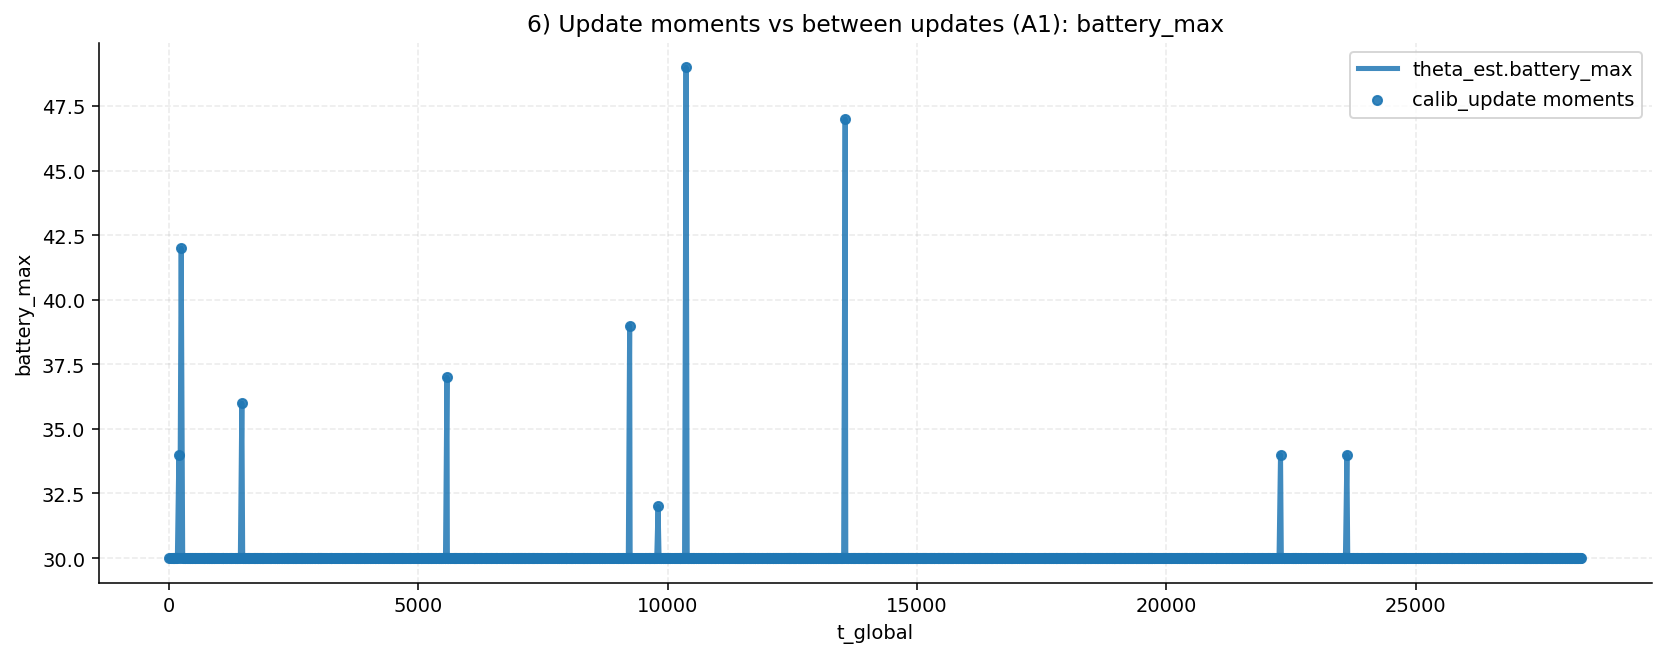

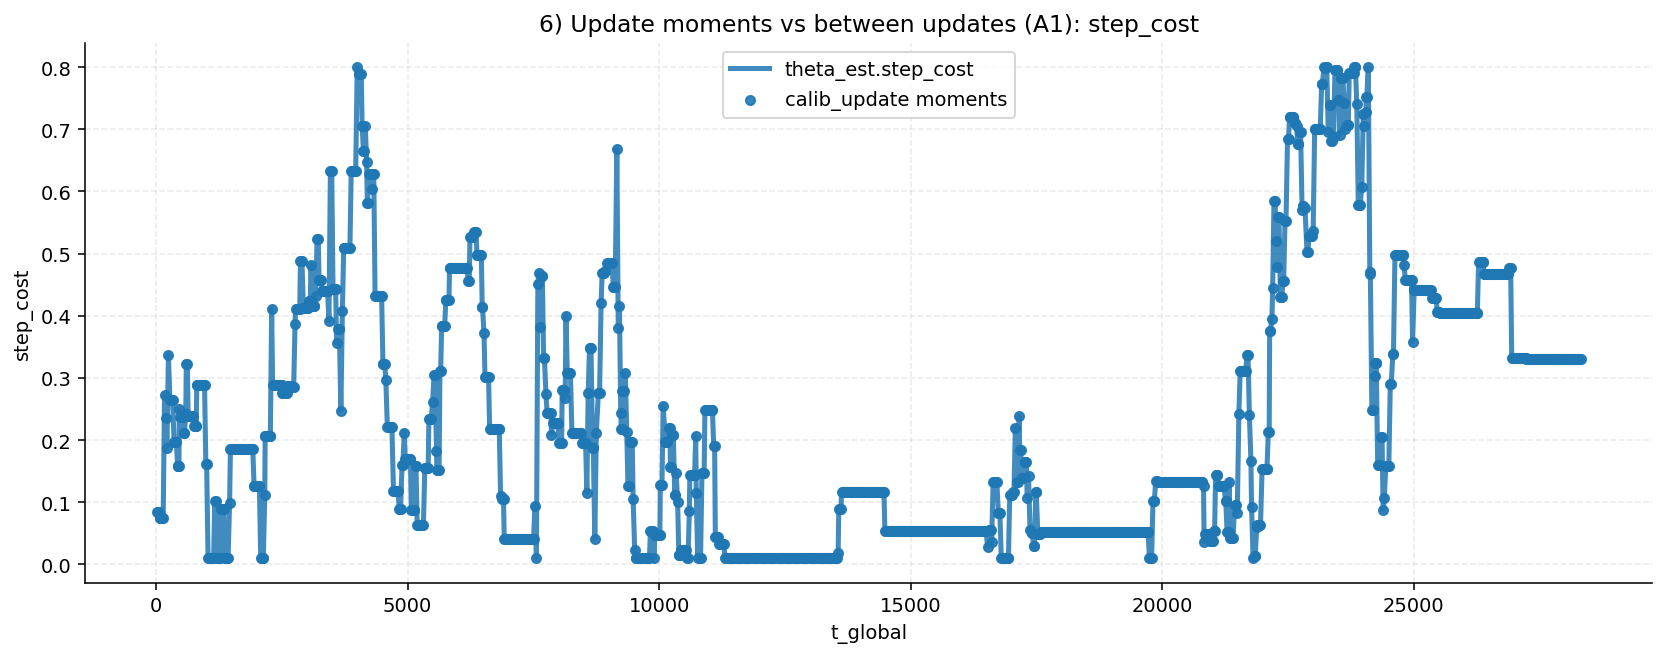

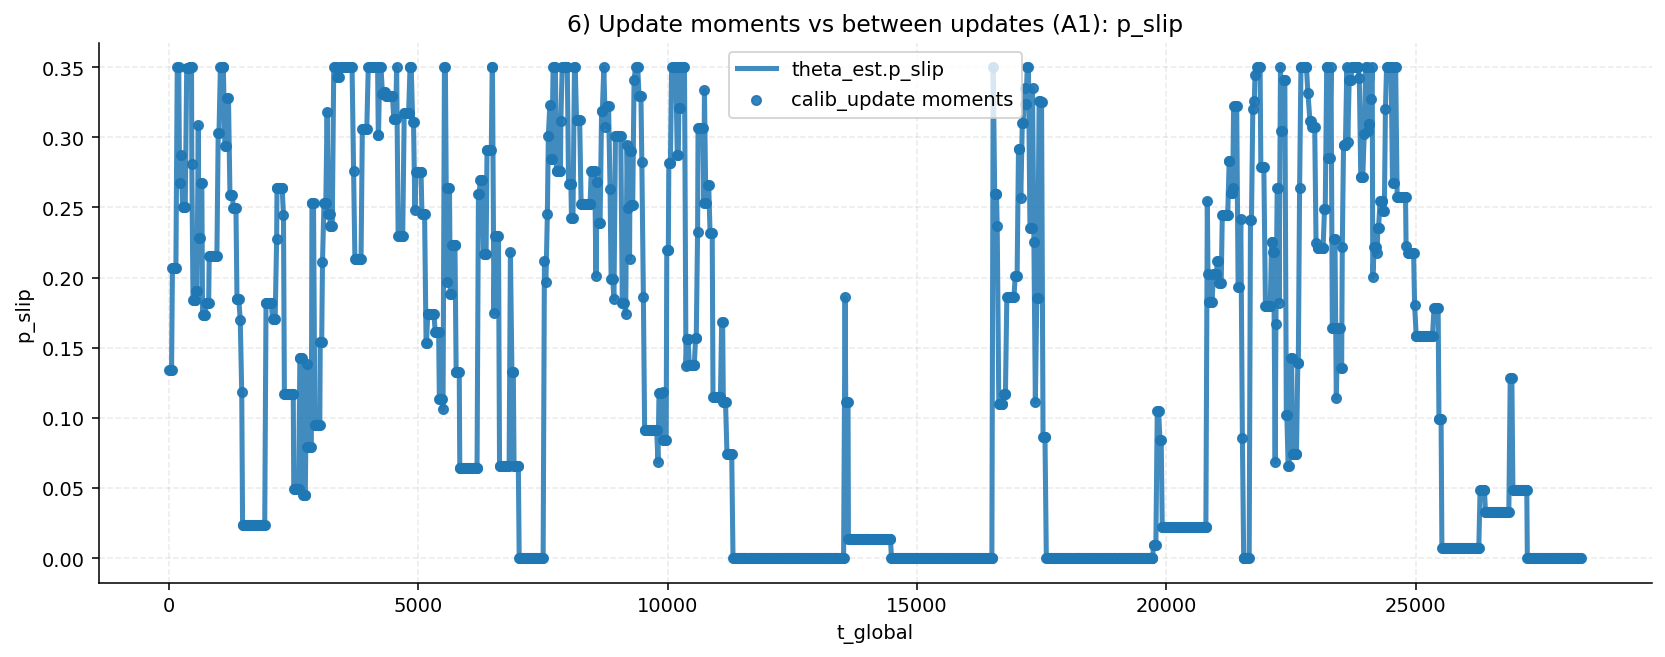

In [41]:
def plot_updates_vs_between_a1(df: pd.DataFrame, param: str,
                               markersize=22,
                               alpha_line=0.85,
                               alpha_pts=0.9):

    d_all = prepare_df_for_plots(df, mode=None, only_updates=False)
    xcol = _pick_xcol(d_all)

    est_col = f"theta_est.{param}"
    if est_col not in d_all.columns:
        raise KeyError(f"Missing '{est_col}' in df.")

    _maybe_num(d_all, est_col)

    # update points (A1 uses calib_update)
    if "event" in d_all.columns:
        is_upd = d_all["event"].astype(str).eq("calib_update")
        d_upd = d_all[is_upd].copy()
    else:
        d_upd = d_all.iloc[0:0].copy()

    plt.figure(figsize=(12, 4.8))
    plt.plot(d_all[xcol], d_all[est_col], linewidth=2.6, alpha=alpha_line, label=est_col)

    if len(d_upd) > 0:
        plt.scatter(d_upd[xcol], d_upd[est_col], s=markersize, alpha=alpha_pts,
                    label="calib_update moments", zorder=5)

    plt.title(f"6) Update moments vs between updates (A1): {param}")
    plt.xlabel(xcol)
    plt.ylabel(param)
    _style_ax(plt.gca())
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

# 6) Update moments vs between updates (A1)
plot_updates_vs_between_a1(upd, param="battery_max")
plot_updates_vs_between_a1(upd, param="step_cost")
plot_updates_vs_between_a1(upd, param="p_slip")

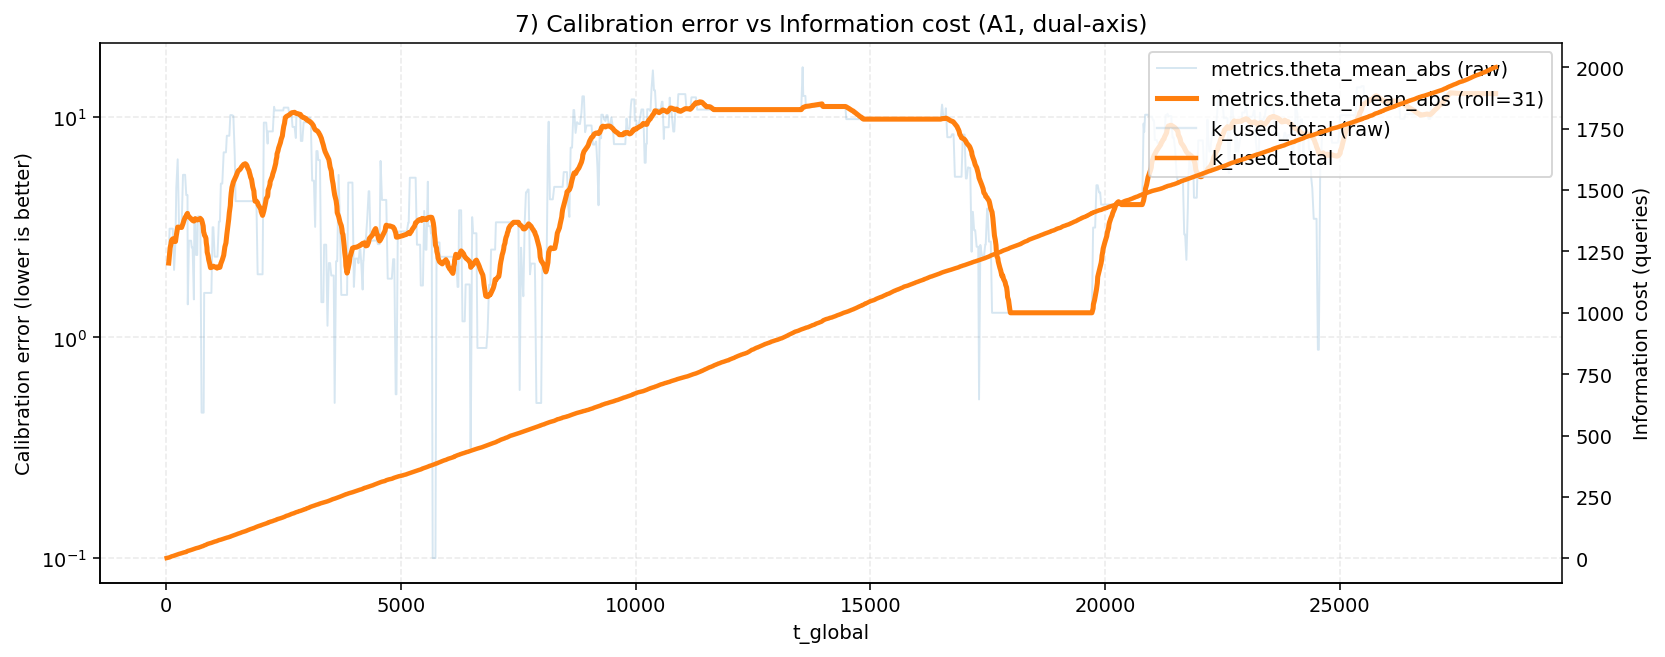

In [42]:
def _pick_a1_accuracy_col(d: pd.DataFrame) -> str:
    for c in ["metrics.theta_mean_abs", "metrics.loss"]:
        if c in d.columns:
            return c
    raise KeyError("No A1 accuracy column found. Expected 'metrics.theta_mean_abs' or 'metrics.loss'.")

def plot_dual_axis_accuracy_queries_a1(df: pd.DataFrame,
                                      acc_col=None,
                                      queries_col="k_used_total",
                                      roll_acc=31,
                                      roll_q=None,
                                      use_symlog=True):
    d = prepare_df_for_plots(df, mode=None, only_updates=False)
    xcol = _pick_xcol(d)

    if acc_col is None:
        acc_col = _pick_a1_accuracy_col(d)

    for c in [acc_col, queries_col]:
        if c not in d.columns:
            raise KeyError(f"Missing column '{c}'")
        _maybe_num(d, c)

    dd = d[[xcol, acc_col, queries_col]].dropna().copy()
    if len(dd) == 0:
        print("Nothing to plot after dropna.")
        return

    x = dd[xcol]
    acc = dd[acc_col]
    q = dd[queries_col]

    acc_s = _rolling(acc, roll_acc) if roll_acc else acc
    q_s = _rolling(q, roll_q) if roll_q else q

    fig, ax1 = plt.subplots(figsize=(12, 4.8))

    ax1.plot(x, acc, alpha=0.18, linewidth=1, label=f"{acc_col} (raw)")
    ax1.plot(x, acc_s, linewidth=2.6, label=f"{acc_col} (roll={roll_acc})")
    ax1.set_xlabel(xcol)
    ax1.set_ylabel("Calibration error (lower is better)")
    if use_symlog:
        ax1.set_yscale("symlog", linthresh=0.1)
    _style_ax(ax1)

    ax2 = ax1.twinx()
    ax2.plot(x, q, alpha=0.15, linewidth=1.2, label=f"{queries_col} (raw)")
    ax2.plot(x, q_s, linewidth=2.3,
             label=f"{queries_col}" + (f" (roll={roll_q})" if roll_q else ""))
    ax2.set_ylabel("Information cost (queries)")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right", frameon=True)

    plt.title("7) Calibration error vs Information cost (A1, dual-axis)")
    plt.tight_layout()
    plt.show()


# 7) Dual-axis: accuracy + queries (A1)
plot_dual_axis_accuracy_queries_a1(
    upd,
    acc_col=None,              # auto: metrics.theta_mean_abs if exists else metrics.loss
    queries_col="k_used_total",
    roll_acc=31,
    roll_q=None,
    use_symlog=True,
)


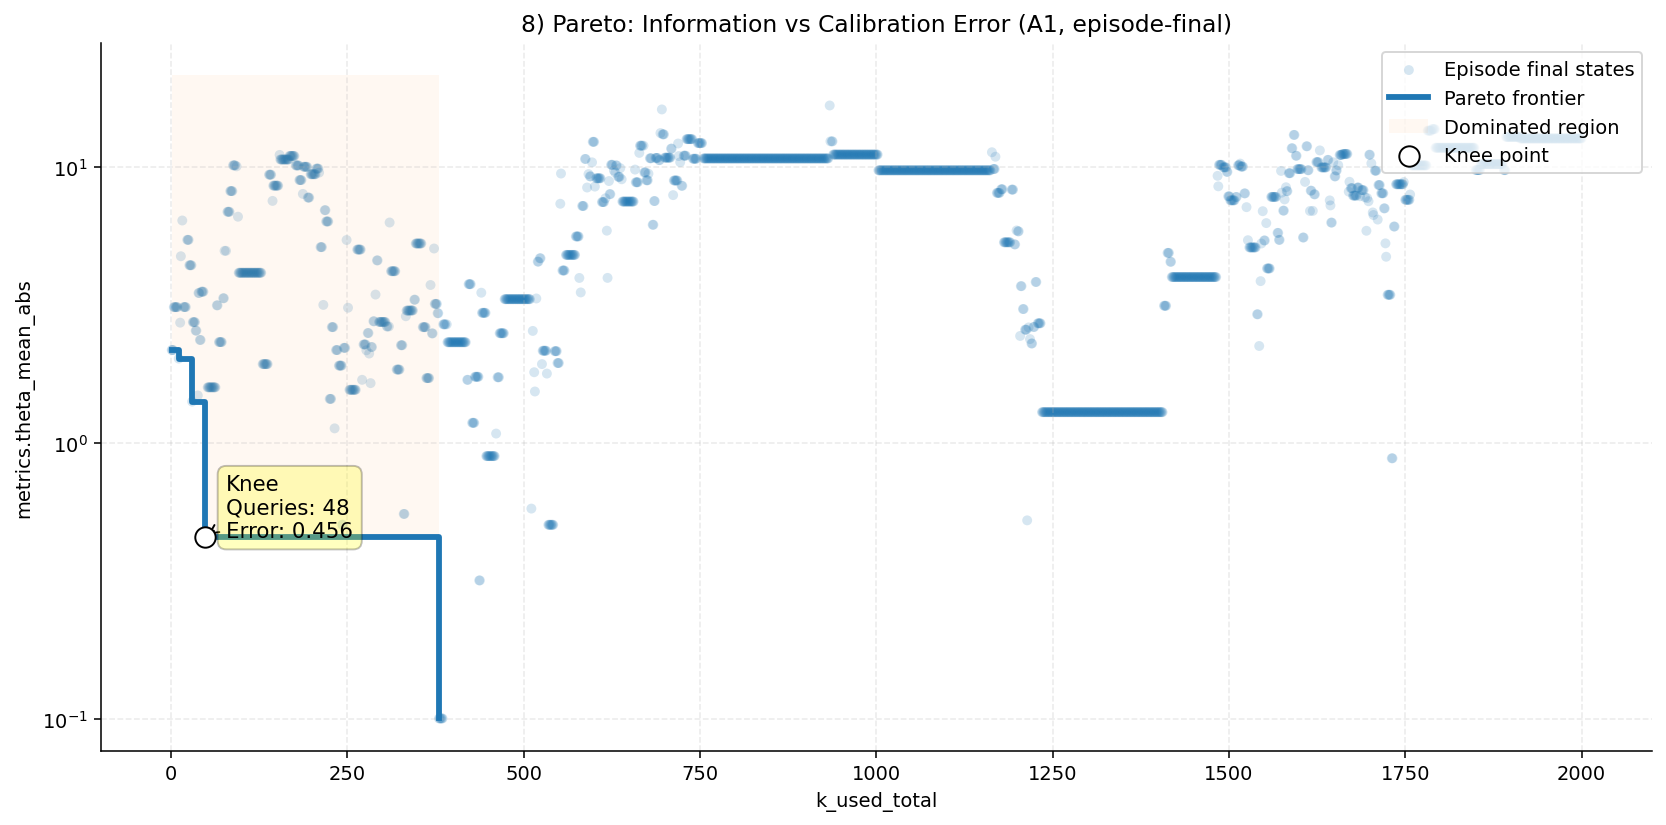

In [44]:
import numpy as np

def pareto_frontier_points(xs: np.ndarray, ys: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Sort by x-axis (cost/queries)
    order = np.argsort(xs)
    _x, _y = xs[order], ys[order]

    # Pick non-dominated points
    px, py = [], []
    current_y_min = np.inf
    for i in range(len(_x)):
        if _y[i] < current_y_min:
            px.append(_x[i])
            py.append(_y[i])
            current_y_min = _y[i]

    return np.array(px), np.array(py)

def staircase_xy(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    sx = np.repeat(x, 2)[1:]
    sy = np.repeat(y, 2)[:-1]
    if len(sx) > 0: # Ensure arrays have data before slicing
        sx = np.concatenate(([x[0]], sx, [x[-1]]))
        sy = np.concatenate(([y[0]], sy, [y[-1]]))
    return sx, sy

def knee_max_distance_to_chord(px: np.ndarray, py: np.ndarray, y_transform: str | None = None) -> int:
    if len(px) < 2:
        return 0

    x1, y1 = px[0], py[0]
    x2, y2 = px[-1], py[-1]

    if y_transform == "log1p":
        y1, y2 = np.log1p(y1), np.log1p(y2)
        py_t = np.log1p(py)
    else:
        py_t = py

    # Calculate distances from points to the chord
    # Line equation: (y - y1)(x2 - x1) - (x - x1)(y2 - y1) = 0
    # Distance: |Ax + By + C| / sqrt(A^2 + B^2)
    # A = (y2 - y1), B = -(x2 - x1), C = -x1(y2 - y1) + y1(x2 - x1)
    A = (y2 - y1)
    B = -(x2 - x1)
    C = -x1 * (y2 - y1) + y1 * (x2 - x1)

    distances = np.abs(A * px + B * py_t + C) / np.sqrt(A**2 + B**2)

    return np.argmax(distances)

def last_calib_update_per_episode_a1(upd: pd.DataFrame) -> pd.DataFrame:
    d = upd.copy()
    if "event" in d.columns:
        d = d[d["event"].astype(str).eq("calib_update")].copy()
    if "ep" not in d.columns:
        raise KeyError("Missing 'ep' in upd for episode grouping.")
    xcol = _pick_xcol(d)
    _maybe_num(d, xcol)
    d = d.dropna(subset=["ep", xcol]).sort_values(xcol)
    return d.groupby("ep", as_index=False).tail(1)

def pareto_plot_episode_frontier_a1(last_ep: pd.DataFrame,
                                   title: str,
                                   x_col="k_used_total",
                                   y_col=None):
    if y_col is None:
        y_col = _pick_a1_accuracy_col(last_ep)

    for c in [x_col, y_col]:
        if c not in last_ep.columns:
            raise KeyError(f"Missing '{c}'")
        _maybe_num(last_ep, c)

    df = last_ep[[x_col, y_col]].dropna()
    df = df[np.isfinite(df[x_col]) & np.isfinite(df[y_col])]
    if len(df) == 0:
        print("Nothing to plot.")
        return

    x = df[x_col].to_numpy(float)
    y = df[y_col].to_numpy(float)

    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, alpha=0.18, s=26, label="Episode final states", edgecolors="none")

    px, py = pareto_frontier_points(x, y)
    if len(px) >= 2:
        sx, sy = staircase_xy(px, py)
        k_idx = knee_max_distance_to_chord(px, py, y_transform="log1p")
        kx, ky = px[k_idx], py[k_idx]

        plt.yscale("symlog", linthresh=0.1)
        plt.plot(sx, sy, linewidth=3, label="Pareto frontier")

        y_top = plt.gca().get_ylim()[1]
        plt.fill_between(sx, sy, y_top, alpha=0.05, label="Dominated region")

        plt.scatter([kx], [ky], color="white", edgecolor="black", s=110, zorder=5, label="Knee point")
        plt.annotate(
            f"Knee\nQueries: {kx:.0f}\nError: {ky:.3f}",
            xy=(kx, ky),
            xytext=(kx + 0.08*(px.max()-px.min()+1e-9), ky),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.15"),
            fontsize=11,
            bbox=dict(boxstyle="round,pad=0.4", fc="yellow", alpha=0.25),
        )
    else:
        plt.yscale("symlog", linthresh=0.1)
        print("WARNING: frontier has <2 points; plotting only scatter.")

    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()


# 8) Pareto: episode-final (A1)
last_ep_a1 = last_calib_update_per_episode_a1(upd)
pareto_plot_episode_frontier_a1(
    last_ep_a1,
    title="8) Pareto: Information vs Calibration Error (A1, episode-final)",
    x_col="k_used_total",
    y_col=None  # auto
)

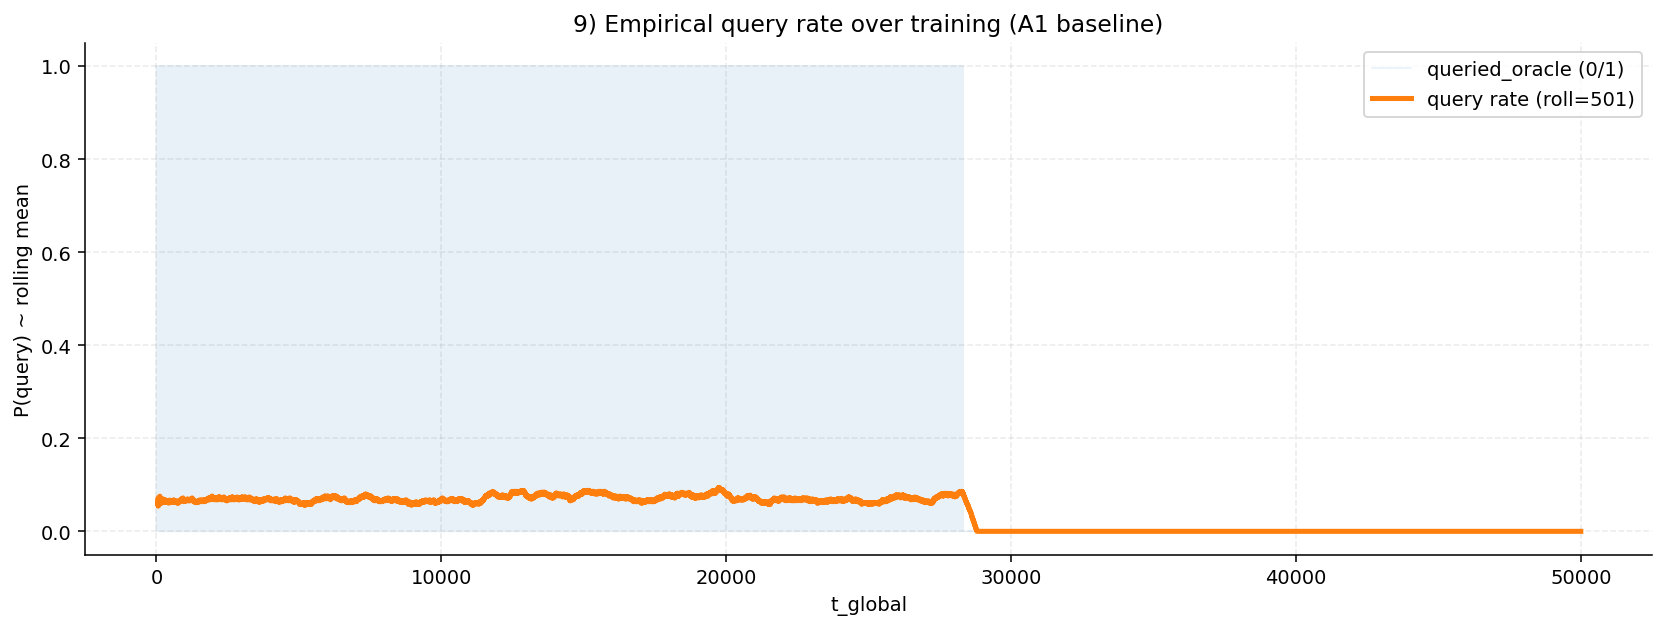

In [12]:
def plot_query_rate_a1(steps_df: pd.DataFrame, roll=501):
    """
    Baseline analog of 'query_cost schedule':
    plots queried_oracle (0/1) and its rolling mean => empirical query rate over time.
    """
    d = steps_df.copy()
    if "t_global" not in d.columns:
        raise KeyError("steps_df must contain 't_global'")
    if "queried_oracle" not in d.columns:
        raise KeyError("steps_df must contain 'queried_oracle'")

    _maybe_num(d, "t_global")
    _maybe_num(d, "queried_oracle")
    d = d.dropna(subset=["t_global", "queried_oracle"]).sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d["t_global"], d["queried_oracle"], alpha=0.10, linewidth=0.8, label="queried_oracle (0/1)")
    plt.plot(d["t_global"], _rolling(d["queried_oracle"], roll), linewidth=2.6, label=f"query rate (roll={roll})")

    plt.title("9) Empirical query rate over training (A1 baseline)")
    plt.xlabel("t_global")
    plt.ylabel("P(query) ~ rolling mean")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()


# 9) Query rate schedule (A1) — needs per-step df
# if you named it differently, pass that df
plot_query_rate_a1(steps, roll=501)



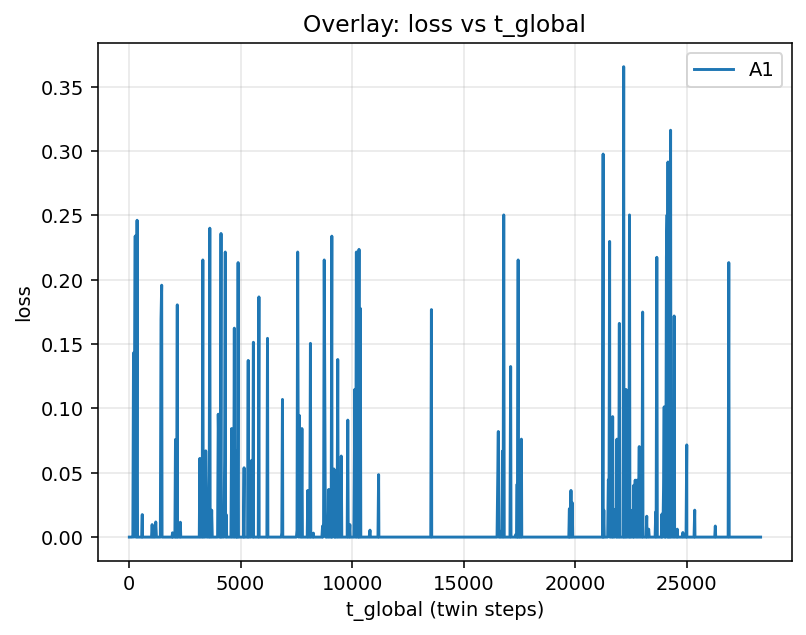

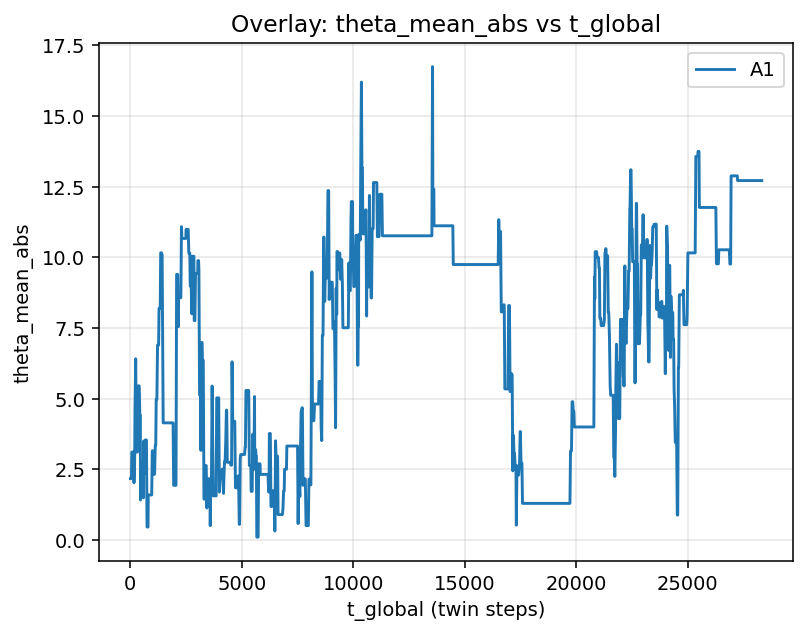

In [24]:
def plot_overlay(all_df: pd.DataFrame, metric: str, labels: list[str], roll: int = 1):
    plt.figure()
    for lab in labels:
        df = all_df[(all_df["label"] == lab) & (all_df["metric"] == metric)].copy()
        if df.empty:
            continue
        x = df["t_global"].to_numpy()
        y = df["value"].to_numpy()
        if roll > 1 and len(y) >= roll:
            y = pd.Series(y).rolling(roll, center=True, min_periods=1).mean().to_numpy()
        plt.plot(x, y, label=lab)

    plt.title(f"Overlay: {metric} vs t_global")
    plt.xlabel("t_global (twin steps)")
    plt.ylabel(metric)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

labels = [k for k in paths.keys()]
plot_overlay(all_df, metric="loss", labels=labels, roll=1)
plot_overlay(all_df, metric="theta_mean_abs", labels=labels, roll=1)
